In [1]:
%load_ext autoreload
%autoreload 2

import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List
from utils import *

import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm
import torchvision.models as models

from torchprofile import profile_macs

assert torch.cuda.is_available(), \
"CUDA support is not available."

import LiveTune as lt

/home/soheil/miniconda3/envs/hardwareAcc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set gpu device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Load Dataset

In [4]:
dataloader = get_dataloader(dataset_name="cifar10", batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


# Define Model (VGG16)

In [5]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.PReLU(num_parameters=1, init=0.1))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.PReLU(num_parameters=1, init=0.1))
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Train functions

In [6]:
def eval(
        model: nn.Module,
        dataloader: DataLoader,
        criterion: nn.Module,
        device: torch.device,
):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss/len(dataloader)

def train(
        model: nn.Module,
        dataloader: DataLoader,
        criterion: nn.Module,
        learning_rate: float,
        device: torch.device,
        epochs: int,
):
    train_losses = []
    val_losses = []
    optimizer = Adam(model.parameters(), lr=learning_rate)
    lr = lt.liveVar(learning_rate, "lr")
    old_lr = learning_rate
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader["train"]):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss/len(dataloader["train"]))
        val_losses.append(eval(model, dataloader["val"], criterion, device))
        print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_losses[-1]} | Val loss: {val_losses[-1]}")
        
        if old_lr != lr():
            optimizer = Adam(model.parameters(), lr=lr())
            old_lr = lr()
            
    return train_losses, val_losses

In [7]:
model_no_reg = VGG16().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()

In [11]:
train_losses, val_losses = train(
    model_no_reg,
    dataloader,
    criterion,
    learning_rate=0.005,
    device=device,
    epochs=20,
)

Warning: [91m[WARN][0m [93mlr already exists. Reusing tag names may have unintended consequences.[0m

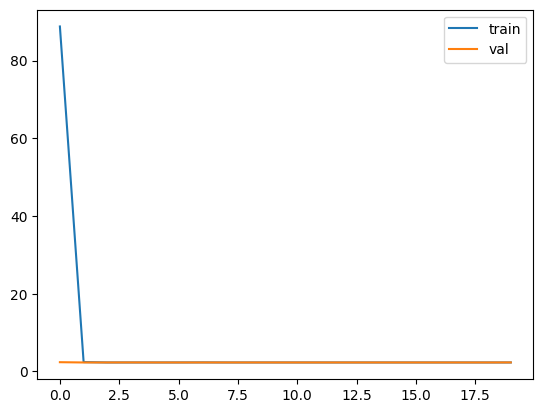

test acc =  9.500000953674316


train acc =  10.380000114440918


In [10]:
# plot losses
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()
print("test acc = ", evaluate(model_no_reg, dataloader["val"], device=device))
print("train acc = ", evaluate(model_no_reg, dataloader["train"], device=device))